# Train a model with Amazon SageMaker Autopilot

### Introduction

In this lab, you will use Amazon Sagemaker Autopilot to train a BERT-based natural language processing (NLP) model. The model will analyze customer feedback and classify the messages into positive (1), neutral (0) and negative (-1) sentiment.

### Table of Contents

- [1. Review transformed dataset](#c1w3-1.)
- [2. Configure the Autopilot job](#c1w3-2.)
  - [2.1. Upload data to S3 bucket](#c1w3-2.1.)
  - [2.2. S3 output for generated assets](#c1w3-2.2.)
  - [2.3. Configure the Autopilot job](#c1w3-2.3.)
    - [Exercise 1](#c1w3-ex-1)
- [3. Launch the Autopilot job](#c1w3-3.)
    - [Exercise 2](#c1w3-ex-2)
- [4. Track Autopilot job progress](#c1w3-4.)
  - [4.1. Autopilot job description](#c1w3-4.1.)
  - [4.2. Autopilot job status](#c1w3-4.2.)
  - [4.3. Review the SageMaker processing jobs](#c1w3-4.3.)
  - [4.4. Wait for the data analysis step to finish](#c1w3-4.4.)
  - [4.5. View generated notebooks](#c1w3-4.5.)
    - [Exercise 3](#c1w3-ex-3)
    - [Exercise 4](#c1w3-ex-4)
- [5. Feature engineering](#c1w3-5.)
    - [Exercise 5](#c1w3-ex-5)
- [6. Model training and tuning](#c1w3-6.)
  - [6.1. Wait for training and tuning](#c1w3-6.1.)
    - [Exercise 6](#c1w3-ex-6)
  - [6.2. Compare model candidates](#c1w3-6.2.)
    - [Exercise 7](#c1w3-ex-7)
  - [6.3. Review best candidate](#c1w3-6.3.)
    - [Exercise 8](#c1w3-ex-8)
- [7. Review all output in S3 bucket](#c1w3-7.)
- [8. Deploy and test best candidate model](#c1w3-8.)
  - [8.1. Deploy best candidate model](#c1w3-8.1.)
  - [8.2. Test the model](#c1w3-8.2.)

Amazon SageMaker Autopilot automatically trains and tunes the best machine learning models for classification or regression, based on your data while allowing to maintain full control and visibility.

SageMaker Autopilot will inspect the raw dataset, apply feature processors, pick the best set of algorithms, train and tune multiple models, and then rank the models based on performance - all with just a few clicks.  Autopilot transparently generates a set of Python scripts and notebooks for a complete end-to-end pipeline including data analysis, candidate generation, feature engineering, and model training/tuning.

SageMaker Autopilot job consists of the following high-level steps: 
* _Data analysis_ where the data is summarized and analyzed to determine which feature engineering techniques, hyper-parameters, and models to explore.
* _Feature engineering_ where the data is scrubbed, balanced, combined, and split into train and validation.
* _Model training and tuning_ where the top performing features, hyper-parameters, and models are selected and trained.

<img src="images/autopilot-transparent.png" width="100%">

These re-usable scripts and notebooks give us full visibility into how the model candidates were created.  Since Autopilot integrates natively with SageMaker Studio, we can visually explore the different models generated by SageMaker Autopilot.

SageMaker Autopilot can be used by people without machine learning experience to automatically train a model from a dataset.  Additionally, experienced developers can use Autopilot to train a baseline model from which they can iterate and manually improve.

Autopilot is available through the SageMaker Studio UI and AWS Python SDK.  In this notebook, you will use the AWS Python SDK to train a series of text-classification models and deploy the model with the highest accuracy.

For more details on Autopilot, have a look at this [**Amazon Science Publication**](https://www.amazon.science/publications/amazon-sagemaker-autopilot-a-white-box-automl-solution-at-scale).

### Use case: analyze customer sentiment

Customer feedback appears across many channels including social media and partner websites.  As a company, you want to capture this valuable product feedback to spot negative trends and improve the situation, if needed. Here you will train a model to classify the feedback messages into positive (1), neutral (0) and negative (-1) sentiment.

First, let's install and import required modules.

In [21]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [22]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore
import time
import json

config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w3')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

<a name='c1w3-1.'></a>
# 1. Review transformed dataset

Let's transform the dataset into a format that Autopilot recognizes.  Specifically, a comma-separated file of `label,features` as shown here:
```
sentiment,review_body
-1,"this is bad"
0,"this is ok"
1,"this is great"
...
```

Sentiment is one of three classes: negative (-1), neutral (0), or positive (1).  Autopilot requires that the target variable, `sentiment` is first and the set of features, just `review_body` in this case, come next.


In [24]:
!aws s3 cp 's3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv' ./

download: s3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv to ./womens_clothing_ecommerce_reviews_balanced.csv


In [25]:
path = './womens_clothing_ecommerce_reviews_balanced.csv'

df = pd.read_csv(path, delimiter=',')
df.head()

,sentiment,review_body,product_category
0,-1,This suit did nothing for me. the top has zero...,Swim
1,-1,Like other reviewers i saw this dress on the ...,Dresses
2,-1,I wish i had read the reviews before purchasin...,Knits
3,-1,I ordered these pants in my usual size (xl) an...,Legwear
4,-1,I noticed this top on one of the sales associa...,Knits


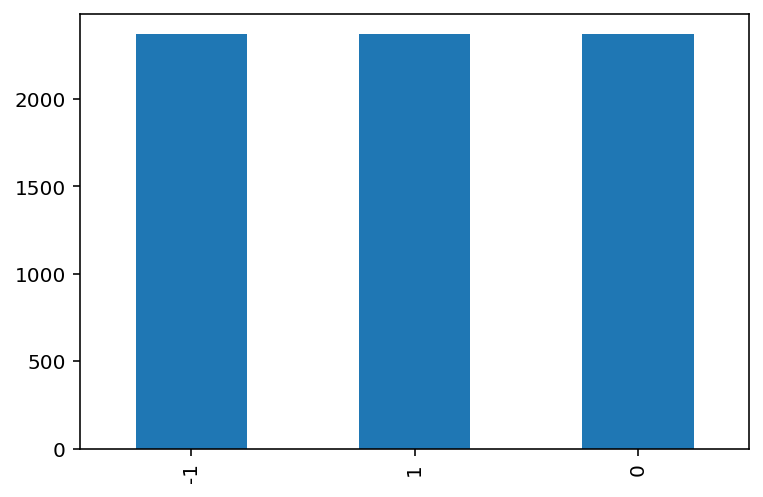

In [26]:
df['sentiment'].value_counts().plot(kind='bar')

In [27]:
path_autopilot = './womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv'

df[['sentiment', 'review_body']].to_csv(path_autopilot, 
                                        sep=',', 
                                        index=False)

<a name='c1w3-2.'></a>
# 2. Configure the Autopilot job

<a name='c1w3-2.1.'></a>
### 2.1. Upload data to S3 bucket

In [28]:
autopilot_train_s3_uri = sess.upload_data(bucket=bucket, key_prefix='autopilot/data', path=path_autopilot)
autopilot_train_s3_uri

's3://sagemaker-us-east-1-479255793468/autopilot/data/womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv'

Check the existence of the dataset in this S3 bucket folder:

In [29]:
!aws s3 ls $autopilot_train_s3_uri

2022-01-03 21:04:01    2253749 womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv


<a name='c1w3-2.2.'></a>
### 2.2. S3 output for generated assets
Set the S3 output path for the Autopilot outputs. This includes Jupyter notebooks (analysis), Python scripts (feature engineering), and trained models.

In [30]:
model_output_s3_uri = 's3://{}/autopilot'.format(bucket)

print(model_output_s3_uri)

s3://sagemaker-us-east-1-479255793468/autopilot


<a name='c1w3-2.3.'></a>
### 2.3. Configure the Autopilot job

Create the Autopilot job name.

In [31]:
import time

timestamp = int(time.time())

auto_ml_job_name = 'automl-dm-{}'.format(timestamp)

When configuring our Autopilot job, you need to specify the maximum number of candidates, `max_candidates`, to explore as well as the input/output S3 locations and target column to predict. In this case, you want to predict `sentiment` from the review text.

<a name='c1w3-ex-1'></a>
### Exercise 1

Configure the Autopilot job.

**Instructions**: Create an instance of the `sagemaker.automl.automl.AutoML` estimator class passing the required configuration parameters. Target attribute for predictions here is `sentiment`.

```python
automl = sagemaker.automl.automl.AutoML(
    target_attribute_name='...', # the name of the target attribute for predictions
    base_job_name=..., # Autopilot job name
    output_path=..., # output data path
    max_candidates=..., # maximum number of candidates
    sagemaker_session=sess,
    role=role,
    max_runtime_per_training_job_in_seconds=1200,
    total_job_runtime_in_seconds=7200
)
```

In [32]:
max_candidates = 3

automl = sagemaker.automl.automl.AutoML(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
   
    target_attribute_name= 'sentiment', # Replace None
    base_job_name= auto_ml_job_name, # Replace None
    output_path= model_output_s3_uri, # Replace None
    
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    
    max_candidates= max_candidates,
    sagemaker_session= sess,
    role= role,
    max_runtime_per_training_job_in_seconds= 1200,
    total_job_runtime_in_seconds= 7200
)

<a name='c1w3-3.'></a>
# 3. Launch the Autopilot job

<a name='c1w3-ex-2'></a>
### Exercise 2

Launch the Autopilot job.

**Instructions**: Call `fit` function of the configured estimator passing the S3 bucket input data path and the Autopilot job name.

```python
automl.fit(
    ..., # input data path
    job_name=auto_ml_job_name, # Autopilot job name
    wait=False, 
    logs=False
)
```

In [33]:
automl.fit(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    autopilot_train_s3_uri, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    job_name= auto_ml_job_name, 
    wait= False, 
    logs= False
)

<a name='c1w3-4.'></a>
# 4. Track Autopilot job progress

Once the Autopilot job has been launched, you can track the job progress directly from the notebook using the SDK capabilities.

<a name='c1w3-4.1.'></a>
### 4.1. Autopilot job description

Function `describe_auto_ml_job` of the Amazon SageMaker service returns the information about the AutoML job in dictionary format. You can review the response syntax and response elements in the [**documentation**](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeAutoMLJob.html).

In [34]:
job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)

<a name='c1w3-4.2.'></a>
### 4.2. Autopilot job status

To track the job progress you can use two response elements: `AutoMLJobStatus` and `AutoMLJobSecondaryStatus`, which correspond to the primary (Completed | InProgress | Failed | Stopped | Stopping) and secondary (AnalyzingData | FeatureEngineering | ModelTuning etc.) job states respectively. To see if the AutoML job has started, you can check the existence of the `AutoMLJobStatus` and `AutoMLJobSecondaryStatus` elements in the job description response.

In this notebook, you will use the following scheme to track the job progress:

```python
# check if the job is still at certain stage
while [check 'AutoMLJobStatus' and 'AutoMLJobSecondaryStatus'] in job_description_response:
    # update the job description response
    job_description_response = automl.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    # print the message the Autopilot job is in the stage ...
    print([message])
    # git a time step to check the status again
    sleep(15)
print("Autopilot job complete...")
```

In [35]:
while 'AutoMLJobStatus' not in job_description_response.keys() and 'AutoMLJobSecondaryStatus' not in job_description_response.keys():
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job has not yet started. Please wait. ')
    # function `json.dumps` encodes JSON string for printing.
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for Autopilot job to start...')
    sleep(15)

print('[OK] AutoML job started.')

[OK] AutoML job started.


<a name='c1w3-4.3.'></a>
### 4.3. Review the SageMaker processing jobs

The Autopilot creates required SageMaker processing jobs during the run:

* First processing job (data splitter) checks the data sanity, performs stratified shuffling and splits the data into training and validation. 
* Second processing job (candidate generator) first streams through the data to compute statistics for the dataset. Then, uses these statistics to identify the problem type, and possible types of every column-predictor: numeric, categorical, natural language, etc.

In [36]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/">processing jobs</a></b>'.format(region)))


You can review the updates on that page during the run of the Autopilot job.

<a name='c1w3-4.4.'></a>
### 4.4. Wait for the data analysis step to finish

Here you will use the same scheme as above to check the completion of the data analysis step. This step can be identified with the (primary) job status value `InProgress` and secondary job status values `Starting` and then `AnalyzingData`.
### _This cell will take approximately 10 minutes to run._

In [37]:
%%time

job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']

if job_status not in ('Stopped', 'Failed'):
    while job_status in ('InProgress') and job_sec_status in ('Starting', 'AnalyzingData'):
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(15)
    print('[OK] Data analysis phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress FeatureEngineering
[OK] Data analysis phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:479255793468:automl-job/automl-dm-1641243843",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sage

Wait for Autopilot to finish generating the notebooks.

<a name='c1w3-4.5.'></a>
### 4.5. View generated notebooks
Once data analysis is complete, SageMaker AutoPilot generates two notebooks: 
* Data exploration
* Candidate definition

Notebooks are included in the AutoML job artifacts generated during the run. Before checking the existence of the notebooks, you can check if the artifacts have been generated.

<a name='c1w3-ex-3'></a>
### Exercise 3

Check if the Autopilot job artifacts have been generated.

**Instructions**: Use status check scheme described above. The generation of artifacts can be identified by existence of `AutoMLJobArtifacts` element in the keys of the job description response.

In [39]:
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
# get the information about the running Autopilot job
job_description_response =  automl.describe_auto_ml_job(job_name= auto_ml_job_name) # Replace None

# keep in the while loop until the Autopilot job artifacts will be generated
while 'AutoMLJobArtifacts' not in job_description_response.keys(): # Replace all None
    # update the information about the running Autopilot job
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name) # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    print('[INFO] Autopilot job has not yet generated the artifacts. Please wait. ')
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for AutoMLJobArtifacts...')
    time.sleep(15)

print('[OK] AutoMLJobArtifacts generated.')

[OK] AutoMLJobArtifacts generated.


Wait for Autopilot to make the notebooks available.

<a name='c1w3-ex-4'></a>
### Exercise 4

Check if the notebooks have been created.

**Instructions**: Use status check scheme described above. Notebooks creation can be identified by existence of `DataExplorationNotebookLocation` element in the keys of the `job_description_response['AutoMLJobArtifacts']` dictionary.

In [40]:
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
# get the information about the running Autopilot job
job_description_response = automl.describe_auto_ml_job(job_name= auto_ml_job_name) # Replace None

# keep in the while loop until the notebooks will be created
while 'DataExplorationNotebookLocation' not in job_description_response['AutoMLJobArtifacts'].keys(): # Replace all None
    # update the information about the running Autopilot job
    job_description_response = automl.describe_auto_ml_job(job_name= auto_ml_job_name) # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    print('[INFO] Autopilot job has not yet generated the notebooks. Please wait. ')
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for DataExplorationNotebookLocation...')
    time.sleep(15)

print('[OK] DataExplorationNotebookLocation found.')   

[OK] DataExplorationNotebookLocation found.


Review the generated resources in S3 directly. Following the link, you can find the notebooks in the folder `notebooks` and download them by clicking on object `Actions`/`Object actions` -> `Download as`/`Download`.

In [41]:
from IPython.core.display import display, HTML

generated_resources = job_description_response['AutoMLJobArtifacts']['DataExplorationNotebookLocation']
download_path = generated_resources.rsplit('/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb')[0]
job_id = download_path.rsplit('/', 1)[-1]

if not job_id: 
    print('No AutoMLJobArtifacts found.')
else: 
    display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/autopilot/{}/sagemaker-automl-candidates/{}/">generated notebooks</a> in S3 bucket</b>'.format(bucket, auto_ml_job_name, job_id)))

<a name='c1w3-5.'></a>
# 5. Feature engineering

<a name='c1w3-ex-5'></a>
### Exercise 5

Check the completion of the feature engineering step.

**Instructions**: Use status check scheme described above. Feature engineering step can be identified with the (primary) job status value `InProgress` and secondary job status value `FeatureEngineering`.

### _This cell will take approximately 10 minutes to run._

In [42]:
%%time

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    while job_status in ('InProgress') and job_sec_status in ('FeatureEngineering'): # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(5)
    print('[OK] Feature engineering phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress
FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress ModelTuning
[OK] Feature engineering phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:479255793468:automl-job/automl-dm-1641243843",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sagemaker-us-east-1-479255793468/autopilot/automl-dm-1641243843/sagemaker-automl-candidates/automl-dm-1641243843-pr-1-3652b4b0df2c4fb3916abc3e9eaee698f02c6/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb",
        "DataExplorationNotebookLocation": "s3://sagemaker-us-east-1-479255793468/autopilot/automl-dm-1641243843/sagemaker-automl-candidates/auto

<a name='c1w3-6.'></a>
# 6. Model training and tuning
When you launched the Autopilot job, you requested that 3 model candidates are generated and compared. Therefore, you should see three (3) SageMaker training jobs below.

In [43]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/">hyper-parameter tuning jobs</a></b>'.format(region)))


<a name='c1w3-6.1.'></a>
### 6.1. Wait for training and tuning

<a name='c1w3-ex-6'></a>
### Exercise 6

Check the completion of the model tuning step.

**Instructions**: Use status check scheme described above. Model tuning step can be identified with the (primary) job status value `InProgress` and secondary job status value `ModelTuning`.

### _This cell will take approximately 5-10 minutes to run._

In [44]:
%%time

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    while job_status in ('InProgress') and job_sec_status in ('ModelTuning'): # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(5)
    print('[OK] Model tuning phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))


InProgress
ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress MaxCandidatesReached
[OK] Model tuning phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:479255793468:automl-job/automl

_Please wait until ^^ Autopilot ^^ completes above_

Finally, you can check the completion of the Autopilot job looking for the `Completed` job status.

In [45]:
%%time

from pprint import pprint

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
pprint(job_description_response)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print('Job status:  {}'.format(job_status))
print('Secondary job status:  {}'.format(job_sec_status))
if job_status not in ('Stopped', 'Failed'):
    while job_status not in ('Completed'):
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print('Job status:  {}'.format(job_status))
        print('Secondary job status:  {}'.format(job_sec_status))        
        time.sleep(10)
    print('[OK] Autopilot job completed.\n')
else:
    print('Job status: {}'.format(job_status))
    print('Secondary job status: {}'.format(job_status))

{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:479255793468:automl-job/automl-dm-1641243843',
 'AutoMLJobArtifacts': {'CandidateDefinitionNotebookLocation': 's3://sagemaker-us-east-1-479255793468/autopilot/automl-dm-1641243843/sagemaker-automl-candidates/automl-dm-1641243843-pr-1-3652b4b0df2c4fb3916abc3e9eaee698f02c6/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb',
                        'DataExplorationNotebookLocation': 's3://sagemaker-us-east-1-479255793468/autopilot/automl-dm-1641243843/sagemaker-automl-candidates/automl-dm-1641243843-pr-1-3652b4b0df2c4fb3916abc3e9eaee698f02c6/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb'},
 'AutoMLJobConfig': {'CompletionCriteria': {'MaxAutoMLJobRuntimeInSeconds': 7200,
                                            'MaxCandidates': 3,
                                            'MaxRuntimePerTrainingJobInSeconds': 1200},
                     'SecurityConfig': {'EnableInterContainerTrafficEncryption': False}},
 'AutoMLJobN

Before moving to the next section make sure the status above indicates `Autopilot job completed`.

<a name='c1w3-6.2.'></a>
### 6.2. Compare model candidates
Once model tuning is complete, you can view all the candidates (pipeline evaluations with different hyperparameter combinations) that were explored by AutoML and sort them by their final performance metric.

<a name='c1w3-ex-7'></a>
### Exercise 7

List candidates generated by Autopilot sorted by accuracy from highest to lowest.

**Instructions**: Use `list_candidates` function passing the Autopilot job name `auto_ml_job_name` with the accuracy field `FinalObjectiveMetricValue`. It returns the list of candidates with the information about them.

```python
candidates = automl.list_candidates(
    job_name=..., # Autopilot job name
    sort_by='...' # accuracy field name
)
```

In [46]:
candidates = automl.list_candidates(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    job_name= auto_ml_job_name, # Replace None
    sort_by='FinalObjectiveMetricValue' # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

You can review the response syntax and response elements of the function `list_candidates` in the [**documentation**](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_AutoMLCandidate.html). Now let's put the candidate existence check into the loop:

In [47]:
while candidates == []:
    candidates = automl.list_candidates(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job is generating the candidates. Please wait.')
    time.sleep(10)

print('[OK] Candidates generated.') 

[OK] Candidates generated.


The information about each of the candidates is in the dictionary with the following keys:

In [48]:
print(candidates[0].keys())

dict_keys(['CandidateName', 'FinalAutoMLJobObjectiveMetric', 'ObjectiveStatus', 'CandidateSteps', 'CandidateStatus', 'InferenceContainers', 'CreationTime', 'EndTime', 'LastModifiedTime', 'CandidateProperties'])


`CandidateName` contains the candidate name and the `FinalAutoMLJobObjectiveMetric` element contains the metric information which can be used to identify the best candidate later. Let's check that they were generated.

In [49]:
while 'CandidateName' not in candidates[0]:
    candidates = automl.list_candidates(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job is generating CandidateName. Please wait. ')
    sleep(10)

print('[OK] CandidateName generated.')

[OK] CandidateName generated.


In [50]:
while 'FinalAutoMLJobObjectiveMetric' not in candidates[0]:
    candidates = automl.list_candidates(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job is generating FinalAutoMLJobObjectiveMetric. Please wait. ')
    sleep(10)

print('[OK] FinalAutoMLJobObjectiveMetric generated.')

[OK] FinalAutoMLJobObjectiveMetric generated.


In [51]:
print(json.dumps(candidates, indent=4, sort_keys=True, default=str))

[
    {
        "CandidateName": "automl-dm-1641243843Qa65X9BHU2Lr-002-09dddd8d",
        "CandidateProperties": {
            "CandidateArtifactLocations": {
                "Explainability": "s3://sagemaker-us-east-1-479255793468/autopilot/automl-dm-1641243843/documentation/explainability/output"
            },
            "CandidateMetrics": [
                {
                    "MetricName": "Accuracy",
                    "Set": "Validation",
                    "Value": 0.5502099990844727
                },
                {
                    "MetricName": "F1macro",
                    "Set": "Validation",
                    "Value": 0.547950029373169
                }
            ]
        },
        "CandidateStatus": "Completed",
        "CandidateSteps": [
            {
                "CandidateStepArn": "arn:aws:sagemaker:us-east-1:479255793468:processing-job/automl-dm-1641243843-db-1-4bc16787468c40668f5029253152118d0641e",
                "CandidateStepName": "automl

You can print the names of the candidates with their metric values:

In [52]:
print("metric " + str(candidates[0]['FinalAutoMLJobObjectiveMetric']['MetricName']))

for index, candidate in enumerate(candidates):
    print(str(index) + "  " 
        + candidate['CandidateName'] + "  " 
        + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))

metric validation:accuracy
0  automl-dm-1641243843Qa65X9BHU2Lr-002-09dddd8d  0.5502099990844727
1  automl-dm-1641243843Qa65X9BHU2Lr-001-a544c046  0.43393999338150024
2  automl-dm-1641243843Qa65X9BHU2Lr-003-37028f09  0.43285998702049255


<a name='c1w3-6.3.'></a>
### 6.3. Review best candidate

Now that you have successfully completed the Autopilot job on the dataset and visualized the trials, you can get the information about the best candidate model and review it.

<a name='c1w3-ex-8'></a>
### Exercise 8

Get the information about the generated best candidate job. 

**Instructions**: Use `best_candidate` function passing the Autopilot job name. This function will give an error if candidates have not been generated.

In [53]:
candidates = automl.list_candidates(job_name=auto_ml_job_name)

if candidates != []:
    best_candidate = automl.best_candidate(
        ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
        job_name= auto_ml_job_name # Replace None
        ### END SOLUTION - DO NOT delete this comment for grading purposes
    )
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))

{
    "CandidateName": "automl-dm-1641243843Qa65X9BHU2Lr-002-09dddd8d",
    "CandidateProperties": {
        "CandidateArtifactLocations": {
            "Explainability": "s3://sagemaker-us-east-1-479255793468/autopilot/automl-dm-1641243843/documentation/explainability/output"
        },
        "CandidateMetrics": [
            {
                "MetricName": "Accuracy",
                "Set": "Validation",
                "Value": 0.5502099990844727
            },
            {
                "MetricName": "F1macro",
                "Set": "Validation",
                "Value": 0.547950029373169
            }
        ]
    },
    "CandidateStatus": "Completed",
    "CandidateSteps": [
        {
            "CandidateStepArn": "arn:aws:sagemaker:us-east-1:479255793468:processing-job/automl-dm-1641243843-db-1-4bc16787468c40668f5029253152118d0641e",
            "CandidateStepName": "automl-dm-1641243843-db-1-4bc16787468c40668f5029253152118d0641e",
            "CandidateStepType": "AWS:

Check the existence of the candidate name for the best candidate.

In [54]:
while 'CandidateName' not in best_candidate:
    best_candidate = automl.best_candidate(job_name=auto_ml_job_name)
    print('[INFO] Autopilot Job is generating BestCandidate CandidateName. Please wait. ')
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))
    sleep(10)

print('[OK] BestCandidate CandidateName generated.')  

[OK] BestCandidate CandidateName generated.


Check the existence of the metric value for the best candidate.

In [55]:
while 'FinalAutoMLJobObjectiveMetric' not in best_candidate:
    best_candidate = automl.best_candidate(job_name=auto_ml_job_name)
    print('[INFO] Autopilot Job is generating BestCandidate FinalAutoMLJobObjectiveMetric. Please wait. ')
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))
    sleep(10)

print('[OK] BestCandidate FinalAutoMLJobObjectiveMetric generated.')  

[OK] BestCandidate FinalAutoMLJobObjectiveMetric generated.


Print the information about the best candidate:

In [56]:
best_candidate_identifier = best_candidate['CandidateName']
print("Candidate name: " + best_candidate_identifier)
print("Metric name: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("Metric value: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

Candidate name: automl-dm-1641243843Qa65X9BHU2Lr-002-09dddd8d
Metric name: validation:accuracy
Metric value: 0.5502099990844727


<a name='c1w3-7.'></a>
# 7. Review all output in S3 bucket

You will see the artifacts generated by Autopilot including the following:
```
data-processor-models/        # "models" learned to transform raw data into features 
documentation/                # explainability and other documentation about your model
preprocessed-data/            # data for train and validation
sagemaker-automl-candidates/  # candidate models which autopilot compares
transformed-data/             # candidate-specific data for train and validation
tuning/                       # candidate-specific tuning results
validations/                  # validation results
```

In [57]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review all <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=autopilot/{}/">output in S3</a></b>'.format(
            bucket, region, auto_ml_job_name
        )
    )
)

<a name='c1w3-8.'></a>
# 8. Deploy and test best candidate model

<a name='c1w3-8.1.'></a>
### 8.1. Deploy best candidate model

While batch transformations are supported, you will deploy our model as a REST Endpoint in this example.

First, you need to customize the inference response. The inference containers generated by SageMaker Autopilot allow you to select the response content for predictions. By default the inference containers are configured to generate the `predicted_label`. But you can add `probability` into the list of inference response keys.

In [58]:
inference_response_keys = ['predicted_label', 'probability']

Now you will create a SageMaker endpoint from the best candidate generated by Autopilot. Wait for SageMaker to deploy the endpoint.

### _This cell will take approximately 5-10 minutes to run._

In [59]:
autopilot_model = automl.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    candidate=best_candidate,
    inference_response_keys=inference_response_keys,
    predictor_cls=sagemaker.predictor.Predictor,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

print('\nEndpoint name:  {}'.format(autopilot_model.endpoint_name))

---------------!
Endpoint name:  sagemaker-sklearn-automl-2022-01-03-21-38-11-890


_Please wait until the ^^ endpoint ^^ is deployed._ 

Review the SageMaker endpoint in the AWS console.

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, autopilot_model.endpoint_name)))

<a name='c1w3-8.2.'></a>
### 8.2. Test the model

Invoke a few predictions for the actual reviews using the deployed endpoint.

In [ ]:
#sm_runtime = boto3.client('sagemaker-runtime')

review_list = ['This product is great!',
               'OK, but not great.',
               'This is not the right product.']

for review in review_list:
    
    # remove commas from the review since we're passing the inputs as a CSV
    review = review.replace(",", "")

    response = sm_runtime.invoke_endpoint(
        EndpointName=autopilot_model.endpoint_name, # endpoint name
        ContentType='text/csv', # type of input data
        Accept='text/csv', # type of the inference in the response
        Body=review # review text
        )

    response_body=response['Body'].read().decode('utf-8').strip().split(',')

    print('Review: ', review, ' Predicated class: {}'.format(response_body[0]))

print("(-1 = Negative, 0=Neutral, 1=Positive)")

You used Amazon SageMaker Autopilot to automatically find the best model, hyper-parameters, and feature-engineering scripts for our dataset. Autopilot uses a uniquely-transparent approach to AutoML by generating re-usable Python scripts and notebooks.

Upload the notebook into S3 bucket for grading purposes.

**Note:** you may need to click on "Save" button before the upload.

In [ ]:
!aws s3 cp ./C1_W3_Assignment.ipynb s3://$bucket/C1_W3_Assignment_Learner.ipynb

Please go to the main lab window and click on `Submit` button (see the `Finish the lab` section of the instructions).